In [16]:
#run in sch_man_nwinvasion-jupyter environment

import os
import shutil
import allel
import math
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from scipy import stats
import itertools
import scipy.spatial
import random
from tqdm import tqdm


In [17]:
os.chdir("/master/nplatt/sch_man_nwinvasion")

# Read in and process data

 Get population assignments

In [18]:
with open('data/pop_assign.yml') as yaml_file:
    pop_assign = yaml.load(yaml_file, Loader=yaml.FullLoader)

read in the vcf file and get pop specific allele counts

In [19]:
#-------------------------------------------------------------------------------
# get genotype info per population

#read in vcf
filtered_callset=allel.read_vcf('results/variant_filtration/smv7_ex_autosomes.vcf')

#now get an index for each sample/population
samples = filtered_callset["samples"]

i=0
pop_idxs = defaultdict(list)   
for sample in samples:  
    pop_idxs[pop_assign[sample]].append(i) 
    i=i+1

pops= list(pop_idxs.keys()) 

#get genotypes
gt=allel.GenotypeArray(filtered_callset['calldata/GT'])

#now get allele count per population
ac=gt.count_alleles()

pop_ac={}
for pop in pops:
    pop_ac[pop] = gt.count_alleles(subpop=pop_idxs[pop])

Find all of the accessible bases (since used probes) and get an idea of the length of each chr

In [20]:
#initialize an list the lenght of each contig to fale
accessible_bases = {}
chrom_length = {}

with open('data/genomes/Smansoni_v7.fa.fai', 'r') as fai:
    for entry in fai:
        chrom, length, *offset = entry.rstrip().split("\t")
        chrom_length[chrom] = int(length)
        accessible_bases[chrom]=[False] * int(length)


#now read the bed
with open('data/renamed-sma_agilent_baits.v7.0.chr_reorderd.bed', 'r') as in_bed_file:
    for bed_entry in in_bed_file:
        chrom, start, stop = bed_entry.rstrip().split("\t")
        for base in range(int(start) - 1, int(stop)):
             accessible_bases[chrom][base]=True


## How many SNPs are segregating on Chr 1 per pop

In [15]:
for pop in ["tanzania", "brazil", "senegal", "niger"]:
    seg=np.sum(pop_ac[pop].is_segregating())
    chr1_seg=np.sum(pop_ac[pop][0:162218].is_segregating())
    print("{} chr1={} total={}".format(pop, chr1_seg, seg))

tanzania chr1=29765 total=98136
brazil chr1=8947 total=33042
senegal chr1=9381 total=35593
niger chr1=6107 total=24017


# Pi, Tajima's D, Theta, Ne

In [45]:
for pop in ["rodhaini", "brazil", "niger", "senegal", "tanzania"]:
    accessible_genome_size = 0
    pi_s=[]
    td_s=[]
    theta_s=[]
    mu=8.1e-9

    #now loop through each chromosome
    for chrom in list(set(filtered_callset['variants/CHROM'])) :
        target_sites = filtered_callset['variants/CHROM'] == chrom

     
        chr_poss = filtered_callset['variants/POS'][target_sites]
        chr_acs  = pop_ac[pop][target_sites]
        chr_len  = len(accessible_bases[chrom])
        

        chr_pi    = allel.sequence_diversity(chr_poss, chr_acs, start=1, stop=chr_len, is_accessible=accessible_bases[chrom])
        chr_theta = allel.watterson_theta(chr_poss, chr_acs, is_accessible=accessible_bases[chrom])
        chr_td    = allel.tajima_d(chr_acs, pos=chr_poss, start=1, stop=chr_len, min_sites=3)


        num_accessible_bases = sum(accessible_bases[chrom])
        theta_s += [chr_theta] * num_accessible_bases
        pi_s    += [chr_pi]    * num_accessible_bases
        td_s    += [chr_td]    * num_accessible_bases

        accessible_genome_size += num_accessible_bases

    pi    = np.mean(pi_s)
    td    = np.mean(td_s)
    theta = np.mean(theta_s)
    ne = theta/(4 * mu)

    outline="{}:{}\t{}\t{}\t{}".format(pop, pi, td, theta, ne)
    print(outline)

rodhaini:0.000482784736658036	0.4786576179515533	0.0004285068495203049	13225.520046922991
brazil:0.0006229634190808082	0.22480080261256646	0.0005842378015352539	18032.03091158191
niger:0.0005282391905747682	-0.5633207858097302	0.000607062748979703	18736.50459813898
senegal:0.000452726735843687	-1.4171249923020972	0.0007125456426101054	21992.149463274858
tanzania:0.0013144180653959314	-0.7287596992860278	0.0016688696510230978	51508.32256244129


# Fst

## genome-wide Fst

In [9]:
pops = [ 'rodhaini', 'caribbean', 'tanzania',
         'senegal',  'niger',     'brazil' ]

pop_combs=list(itertools.combinations(pops, 2)) 

with open("results/fst/genome_wide_fst.csv", 'w') as out_csv:
    out_csv.write("pop1,pop2,fst,se\n")
    print("pop1\tpop2\tfst\tse")

    for pop1, pop2 in pop_combs:

        idxs=[pop_idxs[pop1], pop_idxs[pop2]]

        #allel.average_weir_cockerham_fst(g, subpops, blen, max_allele=None)
        fst, se, block_fsts, jacknife_fsts = allel.average_weir_cockerham_fst(gt, idxs, 100)

        outline="{}\t{}\t{}\t{}".format(pop1, pop2, fst, se)
        print(outline)
        
        out_csv.write(outline.replace("\t", ",")+"\n")

pop1	pop2	fst	SE
rodhaini	caribbean	0.928506200479594	0.0012228434103421389
rodhaini	tanzania	0.8439788473873892	0.001616842545372161
rodhaini	senegal	0.9370016347766583	0.001296004539097002
rodhaini	niger	0.9305794094480899	0.0011327164324128835
rodhaini	brazil	0.9189907169217962	0.001343597256193136
caribbean	tanzania	0.2789521159568736	0.0036073079664987
caribbean	senegal	0.32307932601975586	0.008473085940511469
caribbean	niger	0.23645993744180765	0.00707938775077595
caribbean	brazil	0.15369549738924515	0.006733044751663753
tanzania	senegal	0.41553169413628227	0.00321957992128926
tanzania	niger	0.3478709508995357	0.0031245927121814343
tanzania	brazil	0.3790452130775332	0.0034260999716080004
senegal	niger	0.13546469500849986	0.0042380948004846425
senegal	brazil	0.23465523710207586	0.0046503734975993725
niger	brazil	0.15190265241779138	0.0036320702629908355


## sliding window Fst-UNUSED

In [ ]:


os.chdir("/master/nplatt/sch_man_nwinvasion")

if not os.path.exists("results/fst_per_window"):
    os.mkdir("results/fst_per_window")
    
with open('data/pop_assign.yml') as yaml_file:
    pop_assign = yaml.load(yaml_file, Loader=yaml.FullLoader)

#-----------------------------------
# get lengths from cumul positions
#make sure that all stops are not gt chrom length
chr_length = {}
#genome_size = 0
with open('/master/nplatt/sch_man_nwinvasion/data/genomes/Smansoni_v7.fa.fai', 'r') as fai:
    for entry in fai:
        chrom, length, *offset = entry.rstrip().split("\t")
        chr_length[chrom]=int(length)

    cumul_start={}
    cumul_start['SM_V7_1']=0
    cumul_start['SM_V7_2']= cumul_start['SM_V7_1'] + chr_length['SM_V7_1']
    cumul_start['SM_V7_3']= cumul_start['SM_V7_2'] + chr_length['SM_V7_2']
    cumul_start['SM_V7_4']= cumul_start['SM_V7_3'] + chr_length['SM_V7_3']
    cumul_start['SM_V7_5']= cumul_start['SM_V7_4'] + chr_length['SM_V7_4']
    cumul_start['SM_V7_6']= cumul_start['SM_V7_5'] + chr_length['SM_V7_5']
    cumul_start['SM_V7_7']= cumul_start['SM_V7_6'] + chr_length['SM_V7_6']
    scanned_size = cumul_start['SM_V7_7'] + chr_length['SM_V7_7']

#-------------------------------------------------------------------------------
# get genotype info per population

#read in vcf
callset=allel.read_vcf('results/variant_filtration/smv7_ex_autosomes.vcf')

#now get an index for each sample/population
samples = callset["samples"]

i=0 
pop_idxs = defaultdict(list)   
for sample in samples:  
     pop_idxs[pop_assign[sample]].append(i) 
     i=i+1 

pops= list(pop_idxs.keys()) 

#get genotypes
gt=allel.GenotypeArray(callset['calldata/GT'])

#now get allele count per population
ac=gt.count_alleles()

#for simplicity add maf info to callset data
maf=ac[:, :2].min(axis=1)/ac[:, :2].sum(axis=1)
callset['maf']=maf 

pop_ac={}
for pop in pops:
    pop_ac[pop] = gt.count_alleles(subpop=pop_idxs[pop])
    
#-------------------------------------------------------------------------------
#generate windows
window=100_000

#define an array of window start and stops
window_starts = [int(x - (window/2)) for x in callset['variants/POS']]
window_stops  = [int(x + (window/2)) for x in callset['variants/POS']]

#make sure that window starts are all gt 1
window_starts = [1 if i < 1 else i for i in window_starts]


#make sure that all stops are not gt chrom length
chr_length = {}
#genome_size = 0
with open('/master/nplatt/sch_man_nwinvasion/data/genomes/Smansoni_v7.fa.fai', 'r') as fai:
    for entry in fai:
        chrom, length, *offset = entry.rstrip().split("\t")
        chr_length[chrom]=int(length)
        #genome_size = genome_size + chr_length[chrom]
    
i=0
for stop in window_stops:
    chrom = callset['variants/CHROM'][i]
    
    if stop > chr_length[chrom]:
        window_stops[i]=chr_length[chrom]
    i=i+1
    
windows = np.column_stack((np.array(window_starts), 
                           np.array(window_stops)))

callset['windows']=windows

In [ ]:
#-------------------------------------------------------------------------------
# fst calculations

pops = ["brazil", "tanzania", "niger", "senegal" ]

idx_comps = {"brazil":   [pop_idxs["brazil"],   pop_idxs["tanzania"] + pop_idxs["niger"]  + pop_idxs["senegal"] ],
             "tanzania": [pop_idxs["tanzania"], pop_idxs["brazil"]   + pop_idxs["niger"]  + pop_idxs["senegal"] ],
             "niger":    [pop_idxs["niger"],    pop_idxs["tanzania"] + pop_idxs["brazil"] + pop_idxs["senegal"] ],
             "senegal":  [pop_idxs["senegal"],  pop_idxs["tanzania"] + pop_idxs["niger"]  + pop_idxs["brazil"] ]}

#make comparisons between population
for pop in idx_comps.keys():
    print(pop)
    pop1_idx = idx_comps[pop][0]
    pop2_idx = idx_comps[pop][1]

    fst_s             = []
    fst_calc_window_s = []
    fst_count_s       = []

    #create empty dataframe to store data    
    headers = ["chrom", "pos", "fst", "smoothed_fst", "window", "num_snps", "zscore", "pvalue", "-log10(p)"]
    df=pd.DataFrame(columns=headers) 

    #now loop through each chromosome
    for chrom in list(set(callset['variants/CHROM'])) :
        target_sites = np.logical_and( callset['maf'] < 0.05, 
                                       callset['variants/CHROM'] == chrom )  

        chr_gts  = gt[target_sites]
        chr_poss = callset['variants/POS'][target_sites]
        chr_wins = callset['windows'][target_sites]

        
        fsts, fst_calc_windows, fst_counts =allel.windowed_weir_cockerham_fst(chr_poss, chr_gts, subpops=[pop1_idx, pop2_idx], windows=chr_wins )

        #get rid of nan values
        useful_values = np.logical_and( np.isfinite(fsts), fst_counts>=10) 

        fsts = fsts[useful_values]
        fst_calc_windows = fst_calc_windows[useful_values]
        fst_counts = fst_counts[useful_values]
        chr_poss = chr_poss[useful_values]

        #set negative fst values to 0
        i=0
        for fst in fsts:
            if fst <0:
                fsts[i]=0
            i=i+1        
        
        #smooth
        smoothed_fsts=signal.medfilt(fsts, kernel_size = 101)

        #add data to dataframe/table
        data = list(zip([chrom]*len(fsts), chr_poss, fsts, smoothed_fsts, fst_calc_windows, fst_counts))
        chr_df=pd.DataFrame(data, columns=headers)
        df = df.append(chr_df)

    #add cumul positions
    fig_x_pos_s=[]
    for index, row in df.iterrows(): 
        fig_x_pos_s.append(int(row["pos"]) + int(cumul_start[row['chrom']]))

    df['fig_x_pos']=fig_x_pos_s

    #save data to csv file
    csv_file = "./results/fst_per_window/{}_vs_all_windowed_fst.csv".format(pop)
    df = df.sort_values(["fig_x_pos"], ascending = True)
    df.to_csv(csv_file, index=False, header=True, mode='w')

# F3

In [11]:
#allel.average_patterson_f3(acc, aca, acb, blen, normed=True)[source]

dict_keys(['samples', 'calldata/GT', 'variants/ALT', 'variants/CHROM', 'variants/FILTER_PASS', 'variants/ID', 'variants/POS', 'variants/QUAL', 'variants/REF'])

In [7]:
allel.average_patterson_f3(pop_ac["brazil"],
                           pop_ac["rodhaini"],
                           pop_ac["tanzania"],
                           blen=100,
                           normed=True)


/master/nplatt/miniconda3/envs/sch_man_nwinvasion-jupyter/lib/python3.8/site-packages/allel/stats/admixture.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = (ac[:, 0] * ac[:, 1]) / (an * (an - 1))
/master/nplatt/miniconda3/envs/sch_man_nwinvasion-jupyter/lib/python3.8/site-packages/allel/stats/admixture.py:359: RuntimeWarning: divide by zero encountered in true_divide
  vb = T_bsum / B_bsum
/master/nplatt/miniconda3/envs/sch_man_nwinvasion-jupyter/lib/python3.8/site-packages/allel/stats/admixture.py:359: RuntimeWarning: invalid value encountered in true_divide
  vb = T_bsum / B_bsum


(0.7642687717897145,
 0.02070652497665151,
 36.90956221053494,
 array([2.30770842, 0.38621328, 2.60482947, ..., 2.16391042, 2.00865931,
        0.5053442 ]),
 array([0.76363462, 0.76462773, 0.76375805, ..., 0.76407041, 0.76402817,
        0.76435461]))

In [8]:
allel.average_patterson_f3(pop_ac["niger"],
                           pop_ac["rodhaini"],
                           pop_ac["tanzania"],
                           blen=100,
                           normed=True)

(0.99263110166744,
 0.029885483308429644,
 33.21449050775276,
 array([1.87430761, 0.42550039, 1.06493091, ..., 1.74566325, 8.69340121,
        0.45554722]),
 array([0.99205936, 0.99310809, 0.9925732 , ..., 0.99246997, 0.99211768,
        0.9928036 ]))

In [9]:
allel.average_patterson_f3(pop_ac["senegal"],
                           pop_ac["rodhaini"],
                           pop_ac["tanzania"],
                           blen=100,
                           normed=True)

(1.2648039000192297,
 0.046112799000395034,
 27.42847815437086,
 array([2.30182821, 1.01034066, 7.12026285, ..., 1.39569625, 2.63755556,
        1.16257658]),
 array([1.26427968, 1.26501592, 1.26402984, ..., 1.26485081, 1.26458232,
        1.26490291]))

# D; ABBA BABA

## genome wide

In [ ]:
#allel.average_patterson_d(aca, acb, acc, acd, blen)
allel.average_patterson_d(pop_ac["brazil"],
                          pop_ac["tanzania"],
                          pop_ac["rodhaini"],
                          pop_ac["margrebowiei"],
                          blen=1000)

In [ ]:
allel.average_patterson_d(pop_ac["niger"],
                          pop_ac["tanzania"],
                          pop_ac["rodhaini"],
                          pop_ac["margrebowiei"],
                          blen=1000)

In [ ]:
allel.average_patterson_d(pop_ac["senegal"],
                          pop_ac["tanzania"],
                          pop_ac["rodhaini"],
                          pop_ac["margrebowiei"],
                          blen=1000)

## at region with high rod alleles from loter

In [53]:
#get variants from region: SM_V7_2:31,708,474-32,212,727
x=np.logical_and( filtered_callset['variants/POS'] >= 31_708_474,
                  filtered_callset['variants/POS'] <= 32_212_727)
y=np.logical_and(x,
                 filtered_callset['variants/CHROM'] == "SM_V7_2")



num, den = allel.patterson_d(pop_ac["brazil"][y],
                             pop_ac["tanzania"][y],
                             pop_ac["rodhaini"][y],
                             pop_ac["margrebowiei"][y])

In [65]:
num=num[~np.isnan(num)]
den=den[~np.isnan(den)]

In [82]:
target_d=num.sum()/den.sum()
target_d

-0.8712250892015296

In [69]:
d, se, z, d_block, n_block = allel.average_patterson_d(pop_ac["brazil"],
                                                       pop_ac["tanzania"],
                                                       pop_ac["rodhaini"],
                                                       pop_ac["margrebowiei"],
                                                       blen=1000)


In [81]:
d_block.mean()

-0.016875737747302933

In [76]:
stats.percentileofscore(d_block, target_d, kind="rank")

2.9473684210526314

# D3

In [17]:
os.mkdir("results/d3")

In [7]:
d = allel.pairwise_distance(gt.to_n_alt(), metric='euclidean')

In [8]:
pw_d = scipy.spatial.distance.squareform(d)

In [9]:
pw_df = pd.DataFrame(pw_d, columns = samples, index=samples)
pw_df = pw_df/len(gt)

pw_df.to_csv("results/d3/pairwise_pdistance.csv", sep=",")

In [10]:
samples_per_pop = defaultdict(lambda: [])

for sample in pop_assign:
    pop = pop_assign[sample]
    samples_per_pop[pop].append(sample)
    

In [11]:
def random_block_d3(pop_a, pop_b, pop_c, block_size, gt_array):
    x = random.sample(range(0,len(gt)-block_size), 1)[0]
    block_gt = gt_array[x:x+block_size]
    
    block_dist = allel.pairwise_distance(block_gt.to_n_alt(), metric='euclidean')
    block_dist = scipy.spatial.distance.squareform(block_dist)
    block_df = pd.DataFrame(block_dist, columns = samples, index=samples)
    block_pw_df = block_df/len(gt)

    dac = block_pw_df.loc[samples_per_pop[pop_a], samples_per_pop[pop_c]].values.mean()
    dbc = block_pw_df.loc[samples_per_pop[pop_b], samples_per_pop[pop_c]].values.mean()
    
    d3=(dbc-dac)/(dbc+dac)

    return(d3)

In [12]:
combos = [ ("brazil",    "tanzania"), 
           ("niger",     "tanzania"), 
           ("senegal",   "tanzania"), 
           ("cameroon",  "tanzania"),
           ("caribbean", "tanzania"), 
           ("uganda",    "tanzania") ]

d3s = []
comparison_labels=[]

for pop_a, pop_b in tqdm(combos, desc="Combos"):

    label = "({},{}){}".format(pop_a, pop_b, "Sr")
    comparison_labels.append(label)
    
    combo_d3s=[]
    for i in tqdm(range(0,1_000), desc = "bootstrapping"):
        
        d3 = random_block_d3(pop_a, pop_b, "rodhaini", 1_000, gt)
        combo_d3s.append(d3)
        
    d3s.append(combo_d3s)

Combos:   0%|          | 0/6 [00:00<?, ?it/s]

bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]

bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]

bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]

bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]

bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]

bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]

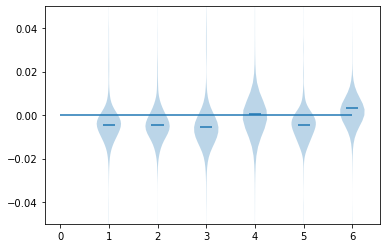

In [13]:
plt.violinplot(d3s, showextrema=False, showmeans=True)
plt.ylim(-0.05, 0.05)
plt.hlines(0, 0, len(d3s))
#plt.xlabels(comparison_labels)
#plt.savefig("results/d3/d3.svg")
plt.show()


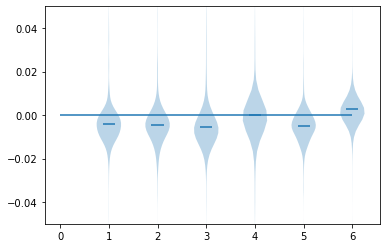

In [10]:
plt.violinplot(d3s, showextrema=False, showmeans=True)
plt.ylim(-0.05, 0.05)
plt.hlines(0, 0, len(d3s))
#plt.xlabels(comparison_labels)
plt.savefig("results/d3/d3.svg")
plt.show()


In [30]:
for i in range(len(d3s)):
    d3_mean = np.array(d3s[i]).mean()
    d3_std = np.array(d3s[i]).std()
    d3_sem = scipy.stats.sem(d3s[i])
    d3_0z = (0-d3_mean)/d3_std
    comp = comparison_labels[i]
    out = "{} - mean {} sem {} z {}".format(comp, d3_mean, d3_sem, d3_0z)
    print(out)

(brazil,tanzania)Sr - mean -0.004720852896774627 sem 0.0003576299668106418 z 0.417641667792854
(niger,tanzania)Sr - mean -0.004560228845382902 sem 0.0003440201099468939 z 0.41939192369931866
(senegal,tanzania)Sr - mean -0.00538156214567549 sem 0.0004817839402108949 z 0.35340549389358533
(cameroon,tanzania)Sr - mean 0.00046427266133737283 sem 0.0006621534770245247 z -0.02218358351490054
(caribbean,tanzania)Sr - mean -0.004753340817546751 sem 0.00029100766329161925 z 0.516787243387249
(uganda,tanzania)Sr - mean 0.0034022709374206647 sem 0.0006169041726716121 z -0.17448915661050748


In [25]:
#z=(x-mean/)SD
#abs(d3_mean)/d3_sem

(0-d3_mean)/d3_std

-0.17448915661050748

In [ ]:
scipy.stats.zscore(d3s[i])

In [29]:
(d3s[i][0]-d3_mean)/d3_std

-0.14801276298268887

# Pi boxplot

In [21]:
pops= list(pop_idxs.keys()) 

#get genotypes
gt=allel.GenotypeArray(filtered_callset['calldata/GT'])

#now get allele count per population
ac=gt.count_alleles()

pop_ac={}
for pop in pops:
    pop_ac[pop] = gt.count_alleles(subpop=pop_idxs[pop])

In [22]:
uniq_chroms=list(set(filtered_callset['variants/CHROM']))
uniq_chroms.sort()

In [216]:
pi_dfs=defaultdict(lambda: pd.DataFrame(columns=["pi", "start", "stop", "n_bases", "n_snps", "chrom"]))

pis=defaultdict(lambda: [])
for pop in tqdm(['rodhaini', 'caribbean', 'brazil', 'niger',  'senegal', 'tanzania']):
    for chrom in uniq_chroms:
        mask=filtered_callset['variants/CHROM']==chrom
        chrom_pos = filtered_callset['variants/POS'][mask]
        chrom_ac = pop_ac[pop][mask]
        pi, windows, nbases, counts = allel.windowed_diversity(chrom_pos, chrom_ac, 100_000, is_accessible=accessible_bases[chrom])

        #add info to a df
        chr_df=pd.DataFrame([pi, windows[:,0], windows[:,1], nbases, counts]).T
        chr_df.columns=["pi", "start", "stop", "n_bases", "n_snps"]
        chr_df["chrom"]=chrom
        
        pi_dfs[pop]=pi_dfs[pop].append(chr_df)
   
    #reset index
    pi_dfs[pop]=pi_dfs[pop].reset_index(drop=True)
        
    #save df to a csv
    pi_dfs[pop].to_csv("results/pi/pi_boxplot_100kb_windows_{}.csv".format(pop), index=False, sep=",")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00, 19.51s/it]


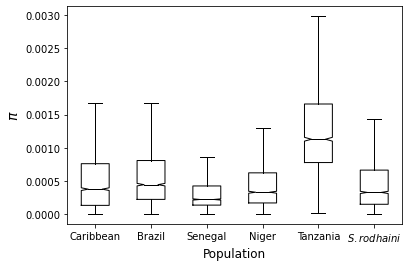

In [605]:
plt.boxplot([pi_dfs["caribbean"][pi_dfs["caribbean"]["n_snps"]>50]["pi"],
             pi_dfs["brazil"][pi_dfs["brazil"]["n_snps"]>50]["pi"],
             pi_dfs["senegal"][pi_dfs["senegal"]["n_snps"]>50]["pi"],
             pi_dfs["niger"][pi_dfs["niger"]["n_snps"]>50]["pi"], 
             pi_dfs["tanzania"][pi_dfs["tanzania"]["n_snps"]>50]["pi"],
             pi_dfs["rodhaini"][pi_dfs["rodhaini"]["n_snps"]>50]["pi"]],
            showfliers=False, 
            notch=True,
            labels=["Caribbean", "Brazil", "Senegal", "Niger", "Tanzania", "$\it{S. rodhaini}$"],
            medianprops=dict(color="black", lw=1))
plt.xlabel("Population", fontsize=12)
plt.ylabel("$\pi$", fontsize=14)
plt.savefig("results/pi/pi_boxplot_100kb_windows.svg")
plt.savefig("results/pi/pi_boxplot_100kb_windows.png", dpi=300)
plt.show()


In [219]:
stats.ttest_ind(pi_dfs["brazil"]["pi"].dropna(), pi_dfs["niger"]["pi"].dropna(), equal_var=False)

Ttest_indResult(statistic=3.228200870883685, pvalue=0.0012528051590282789)

# Tajimas D boxplot

In [23]:
td_dfs=defaultdict(lambda: pd.DataFrame(columns=["tajimas_d", "start", "stop", "n_snps", "chrom"]))

tds=defaultdict(lambda: [])
for pop in tqdm(['rodhaini', 'caribbean', 'brazil', 'niger',  'senegal', 'tanzania']):
    for chrom in uniq_chroms:
        mask=filtered_callset['variants/CHROM']==chrom
        chrom_pos = filtered_callset['variants/POS'][mask]
        chrom_ac = pop_ac[pop][mask]
        td, windows, counts = allel.windowed_tajima_d(chrom_pos, chrom_ac, 100_000, min_sites=3)

        #add info to a df
        chr_df=pd.DataFrame([td, windows[:,0], windows[:,1], counts]).T
        chr_df.columns=["tajimas_d", "start", "stop", "n_snps"]
        chr_df["chrom"]=chrom
        
        td_dfs[pop]=td_dfs[pop].append(chr_df)
        
    #reset index
    td_dfs[pop]=td_dfs[pop].reset_index(drop=True)
    
    #save df to a csv
    td_dfs[pop].to_csv("results/tajimas_d/tajimas_d_boxplot_100kb_windows_{}.csv".format(pop), index=False, sep=",")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.49it/s]


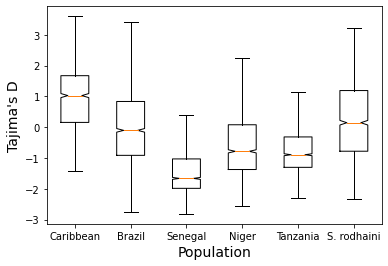

In [24]:
plt.boxplot([td_dfs["caribbean"][td_dfs["caribbean"]["n_snps"]>50]["tajimas_d"].dropna(),
             td_dfs["brazil"][td_dfs["brazil"]["n_snps"]>50]["tajimas_d"].dropna(),
             td_dfs["senegal"][td_dfs["senegal"]["n_snps"]>50]["tajimas_d"].dropna(),
             td_dfs["niger"][td_dfs["niger"]["n_snps"]>50]["tajimas_d"].dropna(), 
             td_dfs["tanzania"][td_dfs["tanzania"]["n_snps"]>50]["tajimas_d"].dropna(),
             td_dfs["rodhaini"][td_dfs["rodhaini"]["n_snps"]>50]["tajimas_d"].dropna() ],
            showfliers=False, 
            notch=True,
            labels=["Caribbean", "Brazil", "Senegal", "Niger", "Tanzania", "S. rodhaini"])
plt.xlabel("Population", fontsize=14)
plt.ylabel("Tajima's D", fontsize=14)
plt.savefig("results/tajimas_d/tajimas_d_boxplot_100kb_windows.svg")
plt.savefig("results/tajimas_d/tajimas_d_boxplot_100kb_windows.png", dpi=300)
plt.show()

In [25]:
for pop in ['rodhaini', 'caribbean', 'brazil', 'niger',  'senegal', 'tanzania']:
    tds=td_dfs[pop][td_dfs[pop]["n_snps"]>50]["tajimas_d"].dropna()
    print("mean TD {} = {}; n={}".format(pop, tds.mean(), len(tds)))

mean TD rodhaini = 0.27421657509536845; n=1712
mean TD caribbean = 0.9292112420732257; n=1292
mean TD brazil = 0.03350175689031385; n=2199
mean TD niger = -0.5789530239728338; n=1962
mean TD senegal = -1.3751618597317719; n=2226
mean TD tanzania = -0.739016026493962; n=2348


In [30]:
import statsmodels.stats.api as sms

brazil_td=td_dfs["brazil"][td_dfs["brazil"]["n_snps"]>50]["tajimas_d"].dropna()

scipy.stats.norm.interval(0.95, loc=np.mean(brazil_td), scale=scipy.stats.sem(brazil_td))

(-0.017530306185466596, 0.0845338199660943)

# Fst target vs. others
Ex Brazil vs. (Niger + Senegal + Tanzania)

In [224]:
fst_dfs=defaultdict(lambda: pd.DataFrame(columns=["fst", "start", "stop", "n_snps", "chrom"]))

#get all idxs for brazil, niger, senegal, and tanzania
idxs=pop_idxs["brazil"] + pop_idxs["niger"] + pop_idxs["senegal"] + pop_idxs["tanzania"]
idxs.sort()

for pop in ['brazil', 'niger',  'senegal', 'tanzania']:
    
    #get non target idxs (ex. all except brazil)
    targ_idxs=pop_idxs[pop]
    subj_idxs=list(set(idxs) - set(targ_idxs))
    
    for chrom in uniq_chroms:
    
        #get only the pos at that chrom
        mask=filtered_callset['variants/CHROM']==chrom
        chrom_pos = filtered_callset['variants/POS'][mask]

        #get genotype array for chrom for the query and subj populations
        query_g = gt[mask].take(pop_idxs["brazil"], axis=1)
        subj_g  = gt[mask].take(subj_idxs, axis=1)
        
        fst, windows, counts = allel.windowed_weir_cockerham_fst(chrom_pos, gt[mask], [targ_idxs, subj_idxs], size=100_00)
        
        #add info to a df
        chr_df=pd.DataFrame([fst, windows[:,0], windows[:,1], counts]).T
        chr_df.columns=["fst", "start", "stop", "n_snps"]
        chr_df["chrom"]=chrom

        fst_dfs[pop]=fst_dfs[pop].append(chr_df)
        
        #set negative fsts to 0
        fst_dfs[pop].loc[fst_dfs[pop]["fst"]<0, "fst"]=0
    
        #reset index
        fst_dfs[pop]=fst_dfs[pop].reset_index(drop=True)
    
    #save df to a csv
    fst_dfs[pop].to_csv("results/fst_per_window/fsts_100kb_windows_{}.csv".format(pop), index=False, sep=",")

  0%|                                                                                                                                                                   | 0/4 [00:00<?, ?it/s]/master/nplatt/sch_man_nwinvasion/envs/sch_man_nwinvasion-pithetafst/lib/python3.9/site-packages/allel/stats/fst.py:409: RuntimeWarning: invalid value encountered in double_scalars
  return np.nansum(wa) / (np.nansum(wa) + np.nansum(wb) + np.nansum(wc))
/master/nplatt/sch_man_nwinvasion/envs/sch_man_nwinvasion-pithetafst/lib/python3.9/site-packages/allel/stats/fst.py:184: RuntimeWarning: invalid value encountered in true_divide
  p = ac / an[:, np.newaxis, :]
/master/nplatt/sch_man_nwinvasion/envs/sch_man_nwinvasion-pithetafst/lib/python3.9/site-packages/allel/stats/fst.py:225: RuntimeWarning: divide by zero encountered in true_divide
  a = ((n_bar / n_C) *
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [226]:
#get all idxs for brazil, niger, senegal, and tanzania
idxs=[pop_idxs["brazil"], pop_idxs["niger"], pop_idxs["senegal"], pop_idxs["tanzania"]]

for chrom in uniq_chroms:

    #get only the pos at that chrom
    mask=filtered_callset['variants/CHROM']==chrom
    chrom_pos = filtered_callset['variants/POS'][mask]

    #get genotype array for chrom for the query and subj populations
    #global_g = gt[mask].take(idxs, axis=1)

    fst, windows, counts = allel.windowed_weir_cockerham_fst(chrom_pos, gt[mask], idxs, size=100_00)

    #add info to a df
    chr_df=pd.DataFrame([fst, windows[:,0], windows[:,1], counts]).T
    chr_df.columns=["fst", "start", "stop", "n_snps"]
    chr_df["chrom"]=chrom

    fst_dfs["global"]=fst_dfs["global"].append(chr_df)

#set negative fsts to 0
fst_dfs["global"].loc[fst_dfs["global"]["fst"]<0, "fst"]=0
    
#reset index
fst_dfs["global"]=fst_dfs["global"].reset_index(drop=True)

#save df to a csv
fst_dfs["global"].to_csv("results/fst_per_window/fsts_100kb_windows_{}.csv".format("global"), index=False, sep=",")

/master/nplatt/sch_man_nwinvasion/envs/sch_man_nwinvasion-pithetafst/lib/python3.9/site-packages/allel/stats/fst.py:184: RuntimeWarning: invalid value encountered in true_divide
  p = ac / an[:, np.newaxis, :]
/master/nplatt/sch_man_nwinvasion/envs/sch_man_nwinvasion-pithetafst/lib/python3.9/site-packages/allel/stats/fst.py:409: RuntimeWarning: invalid value encountered in double_scalars
  return np.nansum(wa) / (np.nansum(wa) + np.nansum(wb) + np.nansum(wc))


In [6]:
fst_dfs=defaultdict(lambda: pd.DataFrame())

for pop in ["brazil", "senegal", "niger", "tanzania", "global"]:
    fst_dfs[pop] = pd.read_csv("results/fst_per_window/fsts_100kb_windows_{}.csv".format(pop), sep=",")

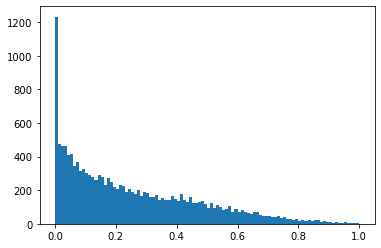

In [11]:
plt.hist(fst_dfs["global"].dropna()["fst"], bins=100)
plt.show()

In [13]:
fst_dfs["global"].dropna()["fst"].mean()

0.24917296343548498

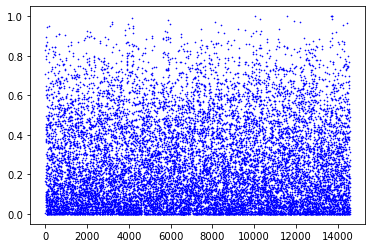

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.68it/s]


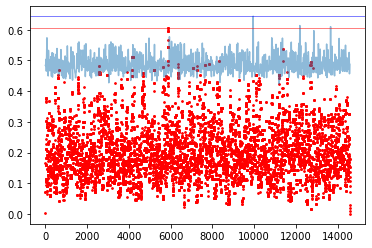

False

In [245]:
from scipy import signal

fst=list(fst_dfs["global"].dropna()["fst"])

#plot raw data
x=list(range(0,len(fst)))
y=fst

plt.scatter(x, y, s=0.4, c="blue")
plt.show()

#plot smoothed data
sy=scipy.signal.medfilt(y, kernel_size=21)
plt.scatter(x, sy, c="red", s=3)

#plot random smoothed data
r_fst=[]
for i in tqdm(range(0, 1_000)):
    y=fst
    random.shuffle(y)
    sry=scipy.signal.medfilt(y, kernel_size=21)
    r=max(sry)
    r_fst.append(r)
    
plt.plot(np.linspace(0, len(x), num=1_000), r_fst, alpha=0.5)

#plot lines showing max random (blue) and max actual (red)
plt.axhline(np.percentile(r_fst, 100), c="blue", linewidth=0.5)
plt.axhline(max(sy), c="red", linewidth=0.5)

plt.show()

#is the max actual (smoothed) greater than the random (smoothed) 
max(sy)>max(r_fst)

In [558]:
#plot global and all pairwise fsts
pw_fst_dfs=defaultdict(lambda: pd.DataFrame(columns=["fst", "start", "stop", "n_snps", "chrom"]))

#get all idxs for brazil, niger, senegal, and tanzania
pops=["brazil", "niger", "senegal", "tanzania"]
combos=itertools.combinations(pops, 2)

for pop1, pop2 in combos:
    print(comp)
    comp="{}_v_{}".format(pop1, pop2)
    for chrom in uniq_chroms:
    
        #get only the pos at that chrom
        mask=filtered_callset['variants/CHROM']==chrom
        chrom_pos = filtered_callset['variants/POS'][mask]
        
        fst, windows, counts = allel.windowed_weir_cockerham_fst(chrom_pos, 
                                                                 gt[mask], 
                                                                 [pop_idxs[pop1], pop_idxs[pop2]], 
                                                                 size=10_000)
        
        
        
        #add info to a df
        chr_df=pd.DataFrame([fst, windows[:,0], windows[:,1], counts]).T
        chr_df.columns=["fst", "start", "stop", "n_snps"]
        chr_df["chrom"]=chrom

        pw_fst_dfs[comp]=pw_fst_dfs[comp].append(chr_df)
        
        #set negative fsts to 0
        pw_fst_dfs[comp].loc[pw_fst_dfs[comp]["fst"]<0, "fst"]=0
    
        #fix indecies
        pw_fst_dfs[comp]=pw_fst_dfs[comp].reset_index(drop=True)
        
    #save df to a csv
    pw_fst_dfs[comp].to_csv("results/fst_per_window/fsts_10kb_windows_{}.csv".format(comp), index=False, sep=",")
    
    

senegal_v_tanzania


/master/nplatt/sch_man_nwinvasion/envs/sch_man_nwinvasion-pithetafst/lib/python3.9/site-packages/allel/stats/fst.py:184: RuntimeWarning: invalid value encountered in true_divide
  p = ac / an[:, np.newaxis, :]
/master/nplatt/sch_man_nwinvasion/envs/sch_man_nwinvasion-pithetafst/lib/python3.9/site-packages/allel/stats/fst.py:225: RuntimeWarning: divide by zero encountered in true_divide
  a = ((n_bar / n_C) *
/master/nplatt/sch_man_nwinvasion/envs/sch_man_nwinvasion-pithetafst/lib/python3.9/site-packages/allel/stats/fst.py:409: RuntimeWarning: invalid value encountered in double_scalars
  return np.nansum(wa) / (np.nansum(wa) + np.nansum(wb) + np.nansum(wc))


brazil_v_niger
brazil_v_senegal
brazil_v_tanzania


/master/nplatt/sch_man_nwinvasion/envs/sch_man_nwinvasion-pithetafst/lib/python3.9/site-packages/allel/stats/fst.py:179: RuntimeWarning: invalid value encountered in true_divide
  n_C = (n_total - (np.sum(n**2, axis=1) / n_total)) / (r - 1)
/master/nplatt/sch_man_nwinvasion/envs/sch_man_nwinvasion-pithetafst/lib/python3.9/site-packages/allel/stats/fst.py:191: RuntimeWarning: invalid value encountered in true_divide
  p_bar = ac_total / an_total[:, np.newaxis]
/master/nplatt/sch_man_nwinvasion/envs/sch_man_nwinvasion-pithetafst/lib/python3.9/site-packages/allel/stats/fst.py:216: RuntimeWarning: invalid value encountered in true_divide
  h_bar = [gs.count_het(allele=allele, axis=1) / n_total
/master/nplatt/sch_man_nwinvasion/envs/sch_man_nwinvasion-pithetafst/lib/python3.9/site-packages/allel/stats/fst.py:227: RuntimeWarning: divide by zero encountered in true_divide
  ((1 / (n_bar - 1)) *
/master/nplatt/sch_man_nwinvasion/envs/sch_man_nwinvasion-pithetafst/lib/python3.9/site-packages/al

niger_v_senegal
niger_v_tanzania


In [559]:
pw_fst_dfs[comp]

,fst,start,stop,n_snps,chrom
0,0.000025,302288.0,312287.0,1.0,SM_V7_1
1,NaN,312288.0,322287.0,0.0,SM_V7_1
2,NaN,322288.0,332287.0,0.0,SM_V7_1
3,NaN,332288.0,342287.0,0.0,SM_V7_1
4,NaN,342288.0,352287.0,0.0,SM_V7_1
...,...,...,...,...,...
30222,0.018421,19040060.0,19050059.0,22.0,SM_V7_7
30223,0.060466,19050060.0,19060059.0,12.0,SM_V7_7
30224,NaN,19060060.0,19070059.0,0.0,SM_V7_7
30225,NaN,19070060.0,19080059.0,8.0,SM_V7_7


In [560]:
#make sure that all stops are not gt chrom length
chr_length = {}
#genome_size = 0
with open('/master/nplatt/sch_man_nwinvasion/data/genomes/Smansoni_v7.fa.fai', 'r') as fai:
    for entry in fai:
        chrom, length, *offset = entry.rstrip().split("\t")
        chr_length[chrom]=int(length)

cumul_start={}
cumul_start['SM_V7_1']=0
cumul_start['SM_V7_2']= cumul_start['SM_V7_1'] + chr_length['SM_V7_1']
cumul_start['SM_V7_3']= cumul_start['SM_V7_2'] + chr_length['SM_V7_2']
cumul_start['SM_V7_4']= cumul_start['SM_V7_3'] + chr_length['SM_V7_3']
cumul_start['SM_V7_5']= cumul_start['SM_V7_4'] + chr_length['SM_V7_4']
cumul_start['SM_V7_6']= cumul_start['SM_V7_5'] + chr_length['SM_V7_5']
cumul_start['SM_V7_7']= cumul_start['SM_V7_6'] + chr_length['SM_V7_6']
scanned_size = cumul_start['SM_V7_7'] + chr_length['SM_V7_7']
    
colors={ "SM_V7_1": "coral",
         "SM_V7_2": "darkturquoise",
         "SM_V7_3": "coral",
         "SM_V7_4": "darkturquoise",
         "SM_V7_5": "coral",
         "SM_V7_6": "darkturquoise",
         "SM_V7_7": "coral",
         "sig":     "red"
       }

ticks=[cumul_start['SM_V7_1'] + (chr_length['SM_V7_1']/2),
       cumul_start['SM_V7_2'] + (chr_length['SM_V7_2']/2),
       cumul_start['SM_V7_3'] + (chr_length['SM_V7_3']/2),
       cumul_start['SM_V7_4'] + (chr_length['SM_V7_4']/2),
       cumul_start['SM_V7_5'] + (chr_length['SM_V7_5']/2),
       cumul_start['SM_V7_6'] + (chr_length['SM_V7_6']/2),
       cumul_start['SM_V7_7'] + (chr_length['SM_V7_7']/2)
      ]

In [561]:
#plot pw_fsts
#add info for figure including x position and the point color
comps=list(pw_fst_dfs.keys())

for comp in comps:
    print(comp)

    for index, row in tqdm(pw_fst_dfs[comp].iterrows()):
        color = colors[row["chrom"]]
        x=int(cumul_start[row["chrom"]] + row["start"])
            
        pw_fst_dfs[comp].at[index,'colors']= color
        pw_fst_dfs[comp].at[index,'x'] = x
    
print("global")
for index, row in tqdm(fst_dfs["global"].iterrows()):
    color = colors[row["chrom"]]
    x=int(cumul_start[row["chrom"]] + row["start"])

    fst_dfs["global"].at[index,'colors']= color
    fst_dfs["global"].at[index,'x'] = x

brazil_v_niger


30227it [00:02, 10724.46it/s]


brazil_v_senegal


30227it [00:02, 10656.27it/s]


brazil_v_tanzania


30227it [00:02, 10608.58it/s]


niger_v_senegal


30227it [00:02, 10642.67it/s]


niger_v_tanzania


30227it [00:02, 10599.58it/s]


senegal_v_tanzania


30227it [00:02, 10619.59it/s]


global


30227it [00:02, 10721.81it/s]


/tmp/ipykernel_37993/2394140980.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


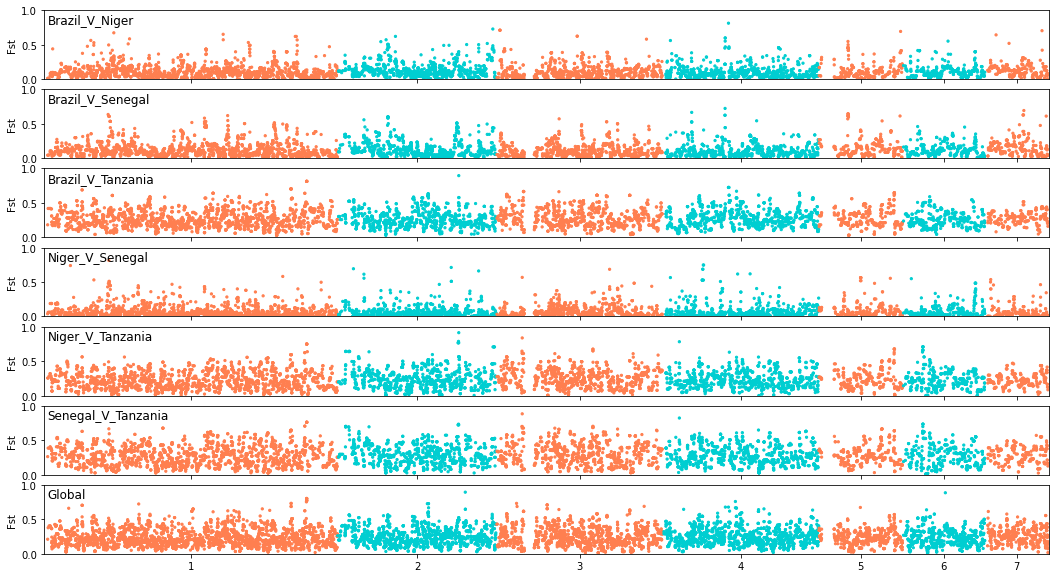

In [562]:
#for pop in ["brazil"]:
fig, axs = plt.subplots(7, sharex=True, gridspec_kw={'hspace': 0.15}, figsize=(18, 10))

i=0
for comp in comps:

    df=pw_fst_dfs[comp].loc[pw_fst_dfs[comp]["n_snps"]>25]
    
    x=df["x"]
    sy=scipy.signal.medfilt(df["fst"], kernel_size=9)
#     sy=df["fst"]
    c=df["colors"]
    label=comp
    
    #plot each seperatley (so the sig points are on top)
    axs[i].scatter(x, sy, marker =".", s = 20, c = c, label = label)
    axs[i].set_ylim( (0, 1) )
    axs[i].set_xlim( (0, cumul_start["SM_V7_7"] + chr_length['SM_V7_7']) )
    axs[i].set(ylabel="Fst".format(comp))
    #axs[i].set_title("{}".format(comp.title()), c="red")
    axs[i].text(1_000_000,0.95, comp.title(),
           horizontalalignment='left',
           verticalalignment='top',
           fontsize=12,
           c="black") 
    #title="{}".format(comp.title())
    #fig.suptitle(title)

    
    i=i+1


df=fst_dfs["global"].loc[fst_dfs["global"]["n_snps"]>10]

x=df["x"]
sy=scipy.signal.medfilt(df["fst"], kernel_size=9)
c=df["colors"]
label="Global"

#plot each seperatley (so the sig points are on top)
axs[i].scatter(x, sy, marker =".", s = 20, c = c, label = label)
axs[i].set_ylim( (0, 1) )
axs[i].set_xlim( (0, cumul_start["SM_V7_7"] + chr_length['SM_V7_7']) )
axs[i].set(ylabel="Fst".format(comp))
axs[i].text(1_000_000,0.95, "Global".title(),
           horizontalalignment='left',
           verticalalignment='top',
           fontsize=12,
           c="black")
#title="{}".format(comp.title())
#fig.suptitle(title)


i=i+1
    
tick_lbls = [ "1", "2", "3", "4", "5", "6" ,"7"]
plt.setp(axs, xticks=ticks, xticklabels=tick_lbls)

                     
plt.tight_layout()
fig.savefig("results/fst_per_window/pairwise_and_global_fst.png".format(pop), dpi=300)
fig.savefig("results/fst_per_window/pairwise_and_global_fst.svg".format(pop)) 
plt.show()
plt.close()

In [563]:
pw_fst_dfs.keys()

dict_keys(['brazil_v_niger', 'brazil_v_senegal', 'brazil_v_tanzania', 'niger_v_senegal', 'niger_v_tanzania', 'senegal_v_tanzania'])

In [564]:
for comp in tqdm(pw_fst_dfs.keys()):
    
    df=pw_fst_dfs[comp]

    a=list(df.loc[df["n_snps"]>10].dropna()["fst"])

    p_s=[]
    for index, row in df.iterrows():
        fst=row["fst"]
        if np.isfinite(fst) and row["n_snps"]>10:
            p=scipy.stats.percentileofscore(a, fst, kind="weak")
            p_s.append(p)
        else: 
            p_s.append(fst)
            
    pw_fst_dfs[comp]["percentile"]=p_s
    #np.percentile(list(pw_fst_dfs["brazil_v_niger"]["fst"]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:58<00:00,  9.74s/it]


In [ ]:
high_diff=97.5

In [593]:
a=set(pw_fst_dfs['brazil_v_niger'].loc[pw_fst_dfs['brazil_v_niger']["percentile"]>high_diff]["x"].values)
b=set(pw_fst_dfs['niger_v_senegal'].loc[pw_fst_dfs['niger_v_senegal']["percentile"]>high_diff]["x"].values)
b=set(pw_fst_dfs['niger_v_tanzania'].loc[pw_fst_dfs['niger_v_tanzania']["percentile"]>high_diff]["x"].values)

list(a.intersection(b))

[214790277.0, 224610277.0, 125283530.0, 104083530.0, 135963530.0, 244054068.0]

In [594]:
a=set(pw_fst_dfs['brazil_v_niger'].loc[pw_fst_dfs['brazil_v_niger']["percentile"]>high_diff]["x"].values)
b=set(pw_fst_dfs['brazil_v_senegal'].loc[pw_fst_dfs['brazil_v_senegal']["percentile"]>high_diff]["x"].values)
c=set(pw_fst_dfs['brazil_v_tanzania'].loc[pw_fst_dfs['brazil_v_tanzania']["percentile"]>high_diff]["x"].values)

a.intersection(b, c)

# # for comp in ['brazil_v_niger', 'brazil_v_senegal', 'brazil_v_tanzania']:
# df=pw_fst_dfs[comp]
# df.loc[df["x"]==x]


{72602288.0, 104083530.0, 206270277.0, 207310277.0, 207320277.0, 261123419.0}

In [595]:
a=set(pw_fst_dfs['niger_v_senegal'].loc[pw_fst_dfs['niger_v_senegal']["percentile"]>high_diff]["x"].values)
b=set(pw_fst_dfs['brazil_v_senegal'].loc[pw_fst_dfs['brazil_v_senegal']["percentile"]>high_diff]["x"].values)
b=set(pw_fst_dfs['senegal_v_tanzania'].loc[pw_fst_dfs['senegal_v_tanzania']["percentile"]>high_diff]["x"].values)

a.intersection(b)

{30312288.0,
 32172288.0,
 32332288.0,
 69552288.0,
 157954992.0,
 159524992.0,
 160914992.0,
 173694992.0,
 173714992.0,
 205400277.0,
 211090277.0,
 234190277.0,
 254254068.0,
 263463419.0,
 271063419.0,
 286545267.0}

In [596]:
a=set(pw_fst_dfs['senegal_v_tanzania'].loc[pw_fst_dfs['senegal_v_tanzania']["percentile"]>high_diff]["x"].values)
b=set(pw_fst_dfs['brazil_v_tanzania'].loc[pw_fst_dfs['brazil_v_tanzania']["percentile"]>high_diff]["x"].values)
c=set(pw_fst_dfs['niger_v_tanzania'].loc[pw_fst_dfs['niger_v_tanzania']["percentile"]>high_diff]["x"].values)

a.intersection(b, c)

{2552288.0,
 2572288.0,
 2982288.0,
 3232288.0,
 4752288.0,
 8332288.0,
 10312288.0,
 11492288.0,
 12382288.0,
 15132288.0,
 15202288.0,
 15432288.0,
 20682288.0,
 25432288.0,
 27502288.0,
 31882288.0,
 35862288.0,
 36272288.0,
 37162288.0,
 37772288.0,
 38502288.0,
 39082288.0,
 41662288.0,
 44742288.0,
 45042288.0,
 48742288.0,
 50222288.0,
 51162288.0,
 51192288.0,
 55522288.0,
 57902288.0,
 59162288.0,
 61612288.0,
 61872288.0,
 65052288.0,
 67542288.0,
 69532288.0,
 72422288.0,
 72512288.0,
 74672288.0,
 74872288.0,
 75812288.0,
 76722288.0,
 76802288.0,
 79512288.0,
 79562288.0,
 79572288.0,
 80022288.0,
 95863530.0,
 101973530.0,
 102003530.0,
 102143530.0,
 104083530.0,
 112213530.0,
 114393530.0,
 115153530.0,
 116353530.0,
 116403530.0,
 116433530.0,
 116463530.0,
 118123530.0,
 127423530.0,
 127613530.0,
 130973530.0,
 145214992.0,
 151824992.0,
 152364992.0,
 152374992.0,
 152404992.0,
 152634992.0,
 154404992.0,
 157324992.0,
 159074992.0,
 163044992.0,
 165774992.0,
 1673

In [520]:
fsts=[]
for comp in tqdm(pw_fst_dfs.keys()):
    
    df=pw_fst_dfs[comp].dropna()
    
    fsts = fsts + list(df.loc[df["n_snps"]>10].dropna()["fst"])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 82.88it/s]


In [556]:
#import math

fst_bt=0.4
fst_st=1
fst_bs=0.4

t_bt=-math.log10(1-fst_bt)
t_st=-math.log10(1-fst_st)
t_bs=-math.log10(1-fst_bs)


pbs=(t_bs + t_bt - t_st)/2
print(pbs)


ValueError: math domain error

In [537]:
pw_fst_dfs['senegal_v_tanzania']

,fst,start,stop,n_snps,chrom,colors,x
0,0.000025,302288.0,312287.0,1.0,SM_V7_1,coral,302288.0
1,NaN,312288.0,322287.0,0.0,SM_V7_1,coral,312288.0
2,NaN,322288.0,332287.0,0.0,SM_V7_1,coral,322288.0
3,NaN,332288.0,342287.0,0.0,SM_V7_1,coral,332288.0
4,NaN,342288.0,352287.0,0.0,SM_V7_1,coral,342288.0
...,...,...,...,...,...,...,...
30222,0.018421,19040060.0,19050059.0,22.0,SM_V7_7,coral,304035267.0
30223,0.060466,19050060.0,19060059.0,12.0,SM_V7_7,coral,304045267.0
30224,NaN,19060060.0,19070059.0,0.0,SM_V7_7,coral,304055267.0
30225,NaN,19070060.0,19080059.0,8.0,SM_V7_7,coral,304065267.0


In [538]:
pw_fst_dfs['niger_v_senegal']

,fst,start,stop,n_snps,chrom,colors,x
0,0.000000,302288.0,312287.0,1.0,SM_V7_1,coral,302288.0
1,NaN,312288.0,322287.0,0.0,SM_V7_1,coral,312288.0
2,NaN,322288.0,332287.0,0.0,SM_V7_1,coral,322288.0
3,NaN,332288.0,342287.0,0.0,SM_V7_1,coral,332288.0
4,NaN,342288.0,352287.0,0.0,SM_V7_1,coral,342288.0
...,...,...,...,...,...,...,...
30222,0.000000,19040060.0,19050059.0,22.0,SM_V7_7,coral,304035267.0
30223,NaN,19050060.0,19060059.0,12.0,SM_V7_7,coral,304045267.0
30224,NaN,19060060.0,19070059.0,0.0,SM_V7_7,coral,304055267.0
30225,NaN,19070060.0,19080059.0,8.0,SM_V7_7,coral,304065267.0
